# Sentiment Analysis Pilpres 2024 Naive bayes classifier
M Fahd Ishamuddin
<br>
<br>

41155050180048
<hr>

In [201]:
%matplotlib inline

import re #regex
import string #string
import pandas as pd #dataframe
import numpy as np #array dan matematika lainnya
import matplotlib.pyplot as plt # data visualisasi
import seaborn as sns #data visualisasi
import collections
import nltk #natural language toolkit
from nltk.tokenize import word_tokenize #tokenisasi
from nltk.sentiment import SentimentIntensityAnalyzer #intensitas sentimen 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory #stopword remover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #stemming

In [202]:
data = pd.read_csv('gab.csv')
print('data ada sebanyak',len(data),'baris')
data = data.drop(['Unnamed: 0'], axis = 1)
print(data.columns)
print(data.dtypes)

data ada sebanyak 124544 baris
Index(['date', 'tweet', 'username'], dtype='object')
date        object
tweet       object
username    object
dtype: object


In [203]:
duplikasi = len(data.tweet)-len(data.tweet.drop_duplicates())
print(f'ada sebanyak {duplikasi} data yang terduplikasi')

ada sebanyak 10867 data yang terduplikasi


In [204]:
x = data.groupby(data.tweet.tolist(), as_index=False).size()
x.sort_values(by='size',ascending=False)

,index,size
94667,RT @PutraErlangga95: Hii tweps mari kita polli...,1573
94492,RT @AnKiiim_: Presiden Erdogan dikalahkan Surv...,433
94523,RT @Box2boxID: Bismillahirrahmannirrahim\n\nLo...,417
94948,RT @tempodotco: Presiden Jokowi Akui Tak Akan ...,392
94657,"RT @PartaiSocmed: Cawe-cawe yang dimaksud, men...",220
...,...,...
37935,"@yusuf_dumdum Bukannya malah aneh, Anies sudah...",1
37934,@yusuf_dumdum Biarkanlah SBY dan Jokowi maju p...,1
37933,@yusuf_dumdum Biarkan acara sholat ied di JIS ...,1
37932,@yusuf_dumdum Betul pak mul. Olh karena itu sa...,1


In [205]:
a = (x['size'] > 1).sum()
print(f'jadi ada tweet sebanyak {a} yang memiliki cuitan yang sama dengan total {duplikasi} tweet')

jadi ada tweet sebanyak 1509 yang memiliki cuitan yang sama dengan total 10867 tweet


In [206]:
data.isna().sum()

date        0
tweet       3
username    6
dtype: int64

In [207]:
tnull_rows = data[data['tweet'].isnull()]
print(tnull_rows)

               date tweet username
108271  mbois_man75   NaN      NaN
108273  mbois_man75   NaN      NaN
108452   ismailpmk_   NaN      NaN


In [208]:
unull_rows = data[data['username'].isnull()]
print(unull_rows)

                             date  \
108270  2022-01-30 02:10:01+00:00   
108271                mbois_man75   
108272  2022-01-30 02:09:48+00:00   
108273                mbois_man75   
108451  2022-01-29 03:49:00+00:00   
108452                 ismailpmk_   

                                                    tweet username  
108270  AHY Ajak Kader Demokrat Bersiap Hadapi Pileg d...      NaN  
108271                                                NaN      NaN  
108272  AHY Ajak Kader Demokrat Bersiap Hadapi Pileg d...      NaN  
108273                                                NaN      NaN  
108451  AHY Ajak Kader Demokrat Bersiap Hadapi Pileg d...      NaN  
108452                                                NaN      NaN  


In [209]:
data = data.dropna()

In [210]:
data.isna().sum()

date        0
tweet       0
username    0
dtype: int64

In [211]:
data = data.drop_duplicates(subset=['tweet'])

In [212]:
len(data)

113675

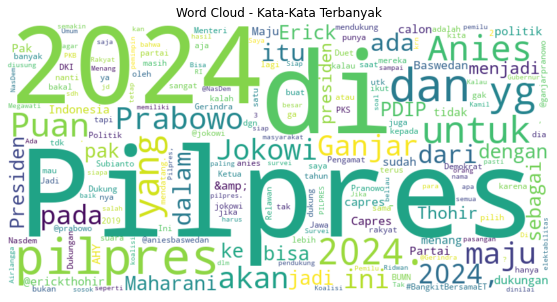

In [213]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_words = ' '.join(str(data['tweet']))
word_counts = data['tweet'].str.split(expand=True).stack().value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Kata-Kata Terbanyak')
plt.show()


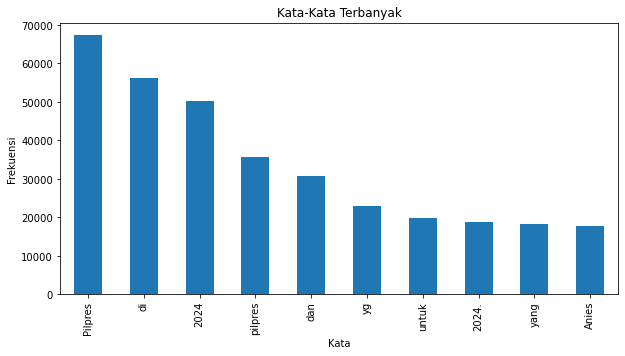

In [214]:
word_counts = data['tweet'].str.split(expand=True).stack().value_counts()
top_words = word_counts.head(10)  # Mengambil 10 kata teratas, ganti jumlah sesuai dengan kebutuhan Anda
plt.figure(figsize=(10, 5))
top_words.plot(kind='bar')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-Kata Terbanyak')
plt.show()

In [215]:
username = data.username.value_counts()
username.head(10)

jpnncom          995
WartaEkonomi     740
detikcom         712
fajaronline      622
OposisiCerdas    481
PUANnews         429
news_wanheart    421
tempodotco       413
SINDOnews        408
KompasTV         403
Name: username, dtype: int64

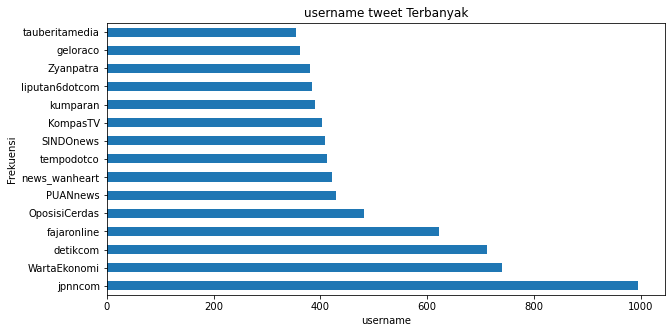

In [216]:
username_top = username.head(15)
plt.figure(figsize=(10, 5))
username_top.plot(kind='barh')
plt.xlabel('username')
plt.ylabel('Frekuensi')
plt.title('username tweet Terbanyak')
plt.show()

In [217]:
len(data)

113675

# FILTERING
regex

In [218]:
data.tweet.iloc[0]

'Berkat kinerja di BUMN, serta kedekatan dengan pemerintah, membuat elektabilitas terus meningkat. Atas dasar itu, dinilai jadi Cawapres terkuat di Pilpres 2024.\n\n@erickthohir\n#BangkitBersamaET https://t.co/1kxqJpwT66'

In [219]:
def preprocess_tweet2(tweet):
    EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])")
    tweet = re.sub(r'[0-9]+','', str(tweet))
    tweet = tweet.lower()  # convert to lower case
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)  # remove URLs
    tweet = re.sub(r'\@\w+|\#\w+', '', tweet)  # remove mentions and hashtags
    tweet = re.sub(r'\d+', '', tweet) # remove numbers
    tweet = re.sub(r'\.',' ', tweet) #
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))  # remove punctuations
    tweet = tweet.strip()
    tweet = re.sub(EMOJI_PATTERN, r'', tweet)
    tweet = re.sub(r'\n+', '', tweet)
    tweet = re.sub(r'^\s+', '', tweet)
    tweet = re.sub(r'\brt', '', tweet)
    return tweet
data['tweet']=data['tweet'].apply(preprocess_tweet2)


In [220]:
data.tweet.iloc[1]

'menggandeng\xa0ulama\xa0hingga\xa0tokoh agama\xa0dalam memberikan suasana adem menjelang\xa0pemilu\xa0 di jateng  menurut ganjar peran mereka sangat penting untuk mengedukasi masyarakat menjelang pilpres'

In [221]:
data = data.dropna()

In [222]:
# duplikasi = len(data.tweet)-len(data.tweet.drop_duplicates())
# print(f'ada sebanyak {duplikasi} data yang terduplikasi')

In [223]:
# x = data.groupby(data.tweet.tolist(), as_index=False).size()
# # x.sort_values(by='size',ascending=False)

In [224]:
# data = data.drop_duplicates(subset=['tweet'])

In [225]:
len(data)

113675

In [226]:
from nltk.tokenize import word_tokenize

def tokenize_column(text):
    if isinstance(text, str):  # Memastikan bahwa text adalah string
        return word_tokenize(text)
    else:
        return []  # Mengembalikan list kosong jika text bukan string

# Contoh penggunaan:
data['tweet'] = data['tweet'].apply(tokenize_column)

In [227]:
data.tweet.iloc[1]

['menggandeng',
 'ulama',
 'hingga',
 'tokoh',
 'agama',
 'dalam',
 'memberikan',
 'suasana',
 'adem',
 'menjelang',
 'pemilu',
 'di',
 'jateng',
 'menurut',
 'ganjar',
 'peran',
 'mereka',
 'sangat',
 'penting',
 'untuk',
 'mengedukasi',
 'masyarakat',
 'menjelang',
 'pilpres']

In [228]:
stemmer = StemmerFactory().create_stemmer()
def stemming(batch):
    # Menerapkan stemming pada setiap teks dalam batch
    stemmed_batch = []
    unique_token = "aasdpemilu"  # Token unik untuk kata "pemilu"
    for text in batch:
        text = text.replace("pemilu", unique_token)
        stemmed_text = stemmer.stem(text) if text.lower() != "pemilu" else text
        stemmed_text = stemmed_text.replace(unique_token, "pemilu")
        stemmed_batch.append(stemmed_text)
    # Melakukan penghapusan stopwords pada setiap teks dalam batch

    return stemmed_batch

# Menambahkan hasil preprocessing ke dalam DataFrame
data['tweet'] = data['tweet'].apply(stemming)

# Hasil preprocessing data
print(data)

                             date  \
0       2022-12-30 23:50:32+00:00   
1       2022-12-30 23:50:16+00:00   
2       2022-12-30 23:40:27+00:00   
3       2022-12-30 23:36:07+00:00   
4       2022-12-30 23:26:47+00:00   
...                           ...   
124518  2023-05-29 01:30:40+00:00   
124524  2023-05-29 01:29:46+00:00   
124538  2023-05-29 01:25:45+00:00   
124539  2023-05-29 01:25:08+00:00   
124542  2023-05-29 01:24:58+00:00   

                                                    tweet         username  
0       [berkat, kerja, di, bumn, serta, dekat, dengan...        Fuad_Lha9  
1       [gandeng, ulama, hingga, tokoh, agama, dalam, ...      iwan_tata98  
2       [mantap, elektabilitas, menteri, bumn, erick, ...        Lima8Satu  
3       [baru, lolos, bagai, serta, pemilu, partai, um...  21BeritaTerkini  
4       [agenda, politik, negara, tuan, rumah, piala, ...      rezakaisar3  
...                                                   ...              ...  
124518  [ganjar,

In [229]:
data.tweet.iloc[1]

['gandeng',
 'ulama',
 'hingga',
 'tokoh',
 'agama',
 'dalam',
 'beri',
 'suasana',
 'adem',
 'jelang',
 'pemilu',
 'di',
 'jateng',
 'turut',
 'ganjar',
 'peran',
 'mereka',
 'sangat',
 'penting',
 'untuk',
 'edukasi',
 'masyarakat',
 'jelang',
 'pilpres']

In [230]:
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
def stopword(batch):
    # Melakukan penghapusan stopwords pada setiap teks dalam batch
    cleaned_batch = [stopword_remover.remove(text) for text in batch]
    cleaned_batch = [text for text in cleaned_batch if all(word not in text.lower() for word in ['yg', 'dgn', 'kl','spt','pk','tp','krn','dr','utk','lg','gw','si','jg','jd','shg','sbg'])]

    return cleaned_batch


# Menambahkan hasil preprocessing ke dalam DataFrame
data['tweet'] = data['tweet'].apply(stopword)

# Hasil preprocessing data
print(data)

                             date  \
0       2022-12-30 23:50:32+00:00   
1       2022-12-30 23:50:16+00:00   
2       2022-12-30 23:40:27+00:00   
3       2022-12-30 23:36:07+00:00   
4       2022-12-30 23:26:47+00:00   
...                           ...   
124518  2023-05-29 01:30:40+00:00   
124524  2023-05-29 01:29:46+00:00   
124538  2023-05-29 01:25:45+00:00   
124539  2023-05-29 01:25:08+00:00   
124542  2023-05-29 01:24:58+00:00   

                                                    tweet         username  
0       [berkat, , , bumn, , , , perintah, , elektabil...        Fuad_Lha9  
1       [gandeng, ulama, , tokoh, agama, , , suasana, ...      iwan_tata98  
2       [mantap, elektabilitas, menteri, bumn, erick, ...        Lima8Satu  
3       [, lolos, , , pemilu, partai, ummat, , bahas, ...  21BeritaTerkini  
4       [agenda, politik, negara, tuan, rumah, piala, ...      rezakaisar3  
...                                                   ...              ...  
124518  [ganjar,

In [231]:
data.tweet.iloc[1]

['gandeng',
 'ulama',
 '',
 'tokoh',
 'agama',
 '',
 '',
 'suasana',
 'adem',
 'jelang',
 'pemilu',
 '',
 'jateng',
 '',
 'ganjar',
 'peran',
 '',
 '',
 '',
 '',
 'masyarakat',
 'jelang',
 'pilpres']

In [232]:
def to_text(daftar_token):
    tokens = [token for token in daftar_token if token != '']
    kalimat = ' '.join(tokens)
    return kalimat
data['tweet'] = data['tweet'].apply(to_text)

In [233]:
from nltk.tokenize import word_tokenize
def labelling(tweet):
    # tweet = preprocess_tweet(tweet)
    clean_tokens = word_tokenize(tweet) #tokenize
    # clean_tokens = [stemmer.stem(word) for word in tweet_tokens if word not in stopwords] #stemming & stopword removal
    positive_words = open("positive.txt").read().splitlines()
    negative_words = open("negative.txt").read().splitlines()
    positive_count = sum([1 for word in clean_tokens if word in positive_words])
    negative_count = sum([1 for word in clean_tokens if word in negative_words])
    if positive_count > negative_count:
        return 'Positive'
    elif positive_count < negative_count:
        return 'Negative'
    else:
        return 'Neutral'
data['sentiment'] = data['tweet'].apply(labelling)

In [234]:
data.sentiment.value_counts()

Neutral     49714
Positive    43522
Negative    20439
Name: sentiment, dtype: int64

In [235]:
dat = len(data.tweet)-len(data.tweet.drop_duplicates())
print(f'ada sebanyak {dat} data yang terduplikasi')

ada sebanyak 18742 data yang terduplikasi


In [236]:
x = data.groupby(data.tweet.to_list(), as_index=False).size()
x.sort_values(by='size',ascending=False)

,index,size
62909,pilpres,275
52991,nasdem bicara duet aniesahy pilpres cocok pend...,101
24201,ganjar dukung maju pilpres tani padi,69
1004,ahy nilai kunci menang pilpres ahy politikus d...,66
835,ahy damping anies pilpres,59
...,...,...
32906,jawabanna diplomatis mantap moga pilpres usung...,1
32905,jawa tulen abdi setia tugiman ambil kucil kont...,1
32904,jawa timurrelawan konco erick thohir rawan nil...,1
32903,jawa timur suara menteri erick thohir idola ma...,1


In [237]:
b = (x['size'] > 1).sum()
print(f'jadi ada tweet sebanyak {b} yang memiliki cuitan yang sama dengan total {dat} tweet')

jadi ada tweet sebanyak 8277 yang memiliki cuitan yang sama dengan total 18742 tweet


In [238]:
data = data.drop_duplicates(subset=['tweet'])

In [239]:
data = data.dropna()

In [240]:
len(data)

94933

In [241]:
data.sentiment.value_counts()

Neutral     40638
Positive    35769
Negative    18526
Name: sentiment, dtype: int64

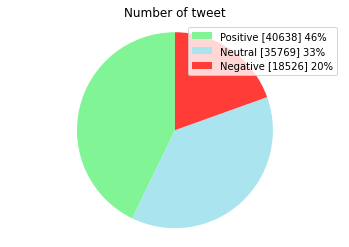

In [242]:
p = 40638
net = 35769
neg = 18526
labels = ['Positive ['+str(p)+'] 46%' , 'Neutral ['+str(net)+'] 33%','Negative ['+str(neg)+'] 20%']
size = [p,net,neg]
colors = ["#81F495","#A9E4EF","#FF3C38"]
patches, texts = plt.pie(size, colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Number of tweet')
plt.axis('equal')
plt.show()

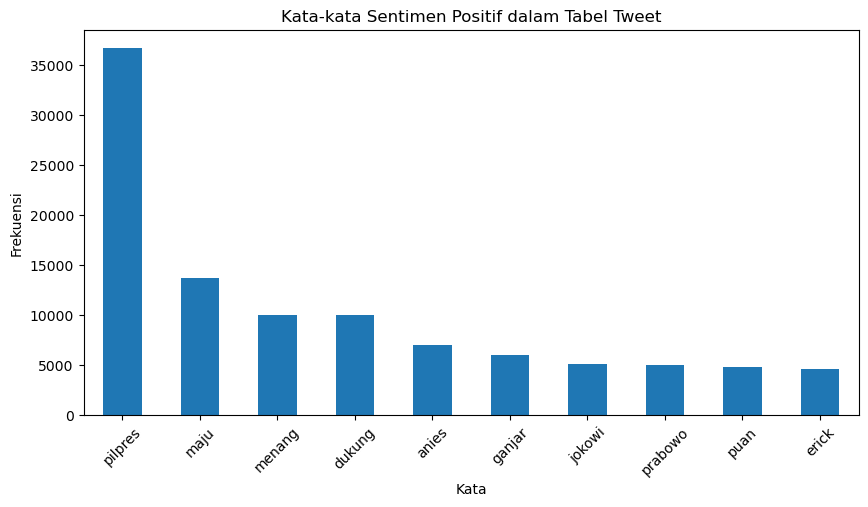

In [243]:
positif_word_counts = data[data['sentiment'] == 'Positive']['tweet'].str.split(expand=True).stack().value_counts()
top_pos_words = positif_word_counts.head(10)
plt.figure(figsize=(10, 5))
top_pos_words.plot(kind='bar')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Sentimen Positif dalam Tabel Tweet')
plt.xticks(rotation=45)
plt.show()

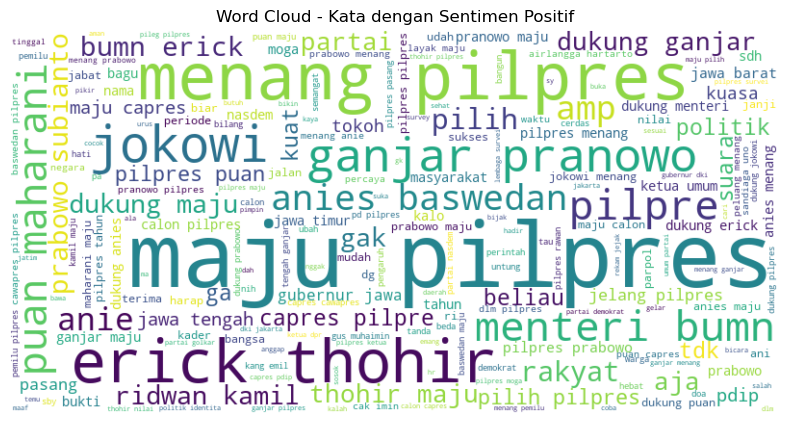

In [244]:
data_positif = data[data['sentiment'] == 'Positive']
all_words_positif = ' '.join(data_positif['tweet'])
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(all_words_positif)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Kata dengan Sentimen Positif')
plt.show()

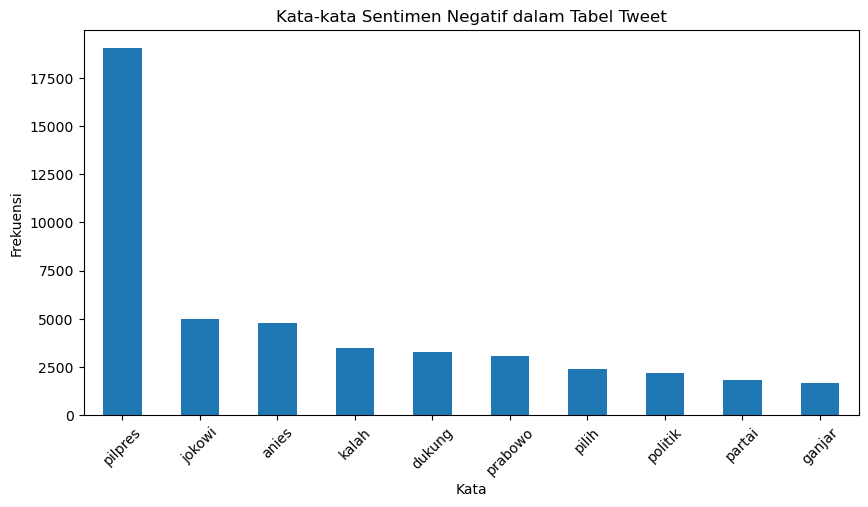

In [245]:
negatif_word_counts = data[data['sentiment'] == 'Negative']['tweet'].str.split(expand=True).stack().value_counts()
top_negatif_words = negatif_word_counts.head(10)
plt.figure(figsize=(10, 5))
top_negatif_words.plot(kind='bar')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Sentimen Negatif dalam Tabel Tweet')
plt.xticks(rotation=45)
plt.show()

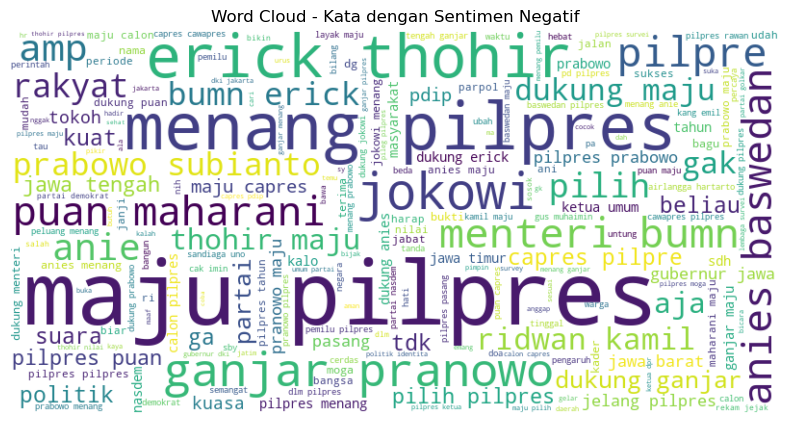

In [246]:
data_negatif = data[data['sentiment'] == 'Negative']
all_words_neg = ' '.join(data_negatif['tweet'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(all_words_positif)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Kata dengan Sentimen Negatif')
plt.show()

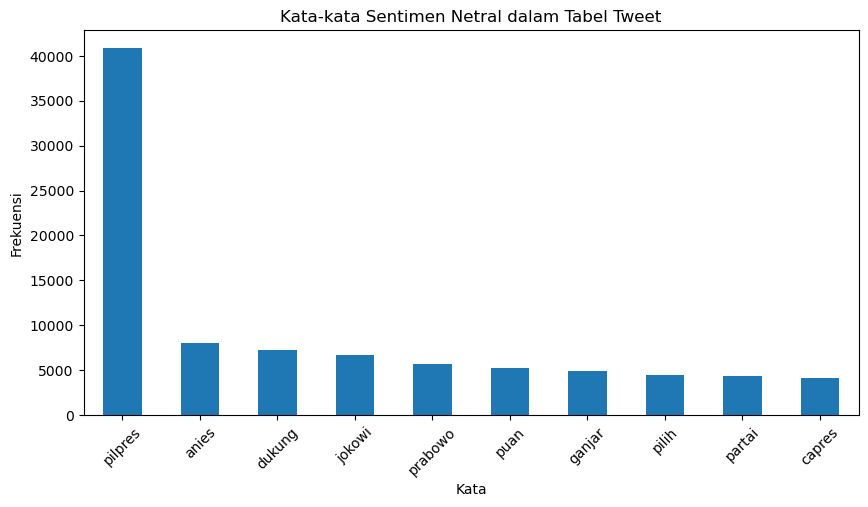

In [247]:
netral_word_counts = data[data['sentiment'] == 'Neutral']['tweet'].str.split(expand=True).stack().value_counts()
top_net_words = netral_word_counts.head(10)
plt.figure(figsize=(10, 5))
top_net_words.plot(kind='bar')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Sentimen Netral dalam Tabel Tweet')
plt.xticks(rotation=45)
plt.show()

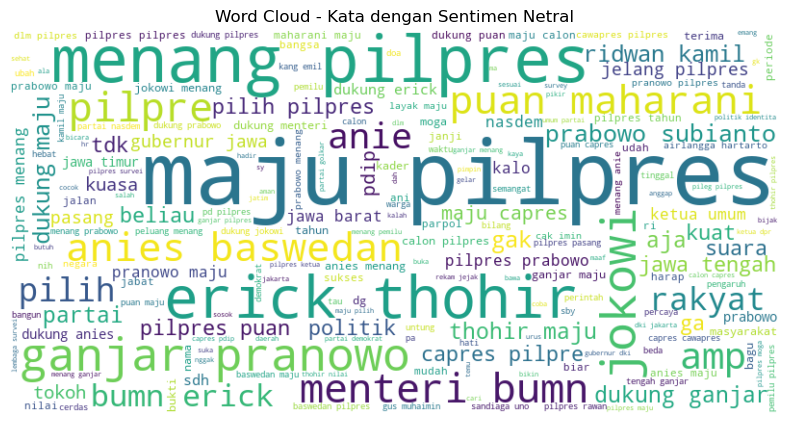

In [248]:
data_netral = data[data['sentiment'] == 'Neutral']
all_words_net = ' '.join(data_negatif['tweet'])
wordcloud_net = WordCloud(width=800, height=400, background_color='white').generate(all_words_positif)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_net, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Kata dengan Sentimen Netral')
plt.show()

In [249]:
data.isnull().sum()

date         0
tweet        0
username     0
sentiment    0
dtype: int64

epoch: 1 acc: 0.7132248380470848
epoch: 2 acc: 0.7132248380470848
epoch: 3 acc: 0.7132248380470848
epoch: 4 acc: 0.7132248380470848
epoch: 5 acc: 0.7132248380470848
epoch: 6 acc: 0.7132248380470848
epoch: 7 acc: 0.7132248380470848
epoch: 8 acc: 0.7132248380470848
epoch: 9 acc: 0.7132248380470848
epoch: 10 acc: 0.7132248380470848


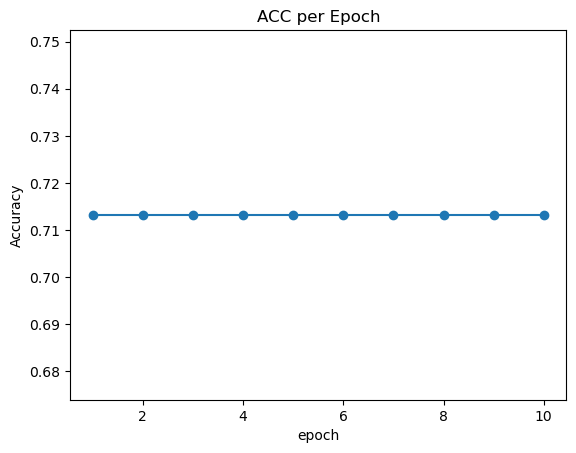

Akurasi: 71.32%


In [250]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

vectorizer = CountVectorizer()

# Melakukan transformasi teks menjadi vektor fitur
X = vectorizer.fit_transform(data['tweet'].astype(str))
# Y = vectorizer.fit_transform(data['sentiment'])

epoch = 10
accuracy_values = np.zeros(epoch)
# Membagi data menjadi data latih dan data uji
for epochs in range(epoch):
    X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.2, random_state=42)
    naive_bayes = MultinomialNB()
    training = naive_bayes.fit(X_train, y_train)
    prediction =  naive_bayes.predict(X_test)

    accuracy = accuracy_score(y_test, prediction)
    accuracy_values[epochs] = accuracy

    print("epoch:", epochs + 1, "acc:", accuracy)
plt.plot(range(1,epoch + 1), accuracy_values, marker='o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('ACC per Epoch')
plt.show()



y_pred = naive_bayes.predict(X_test)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi: {:.2f}%".format(accuracy * 100))

# MCCV

Iterasi 1: 0.7132248380470848
Iterasi 2: 0.7121188181387265
Iterasi 3: 0.7098541107073261
Iterasi 4: 0.7083267498814979
Iterasi 5: 0.7125928266708801
Iterasi 6: 0.7075367356612419
Iterasi 7: 0.7183862642860905
Iterasi 8: 0.7209143097909095
Iterasi 9: 0.7109074630010007
Iterasi 10: 0.7136461789645547
Iterasi 11: 0.7139095170379733
Iterasi 12: 0.7152262074050666
Iterasi 13: 0.708695423184284
Iterasi 14: 0.7168062358455786
Iterasi 15: 0.714962869331648
Iterasi 16: 0.7126454942855638
Iterasi 17: 0.7110127982303681
Iterasi 18: 0.7142781903407595
Iterasi 19: 0.7123821562121452
Iterasi 20: 0.7148575341022805
Iterasi 21: 0.711434139147838
Iterasi 22: 0.7107494601569495
Iterasi 23: 0.7174382472217833
Iterasi 24: 0.7193342813503977
Iterasi 25: 0.7111181334597356
Iterasi 26: 0.7153842102491178
Iterasi 27: 0.7098014430926424
Iterasi 28: 0.7091694317164375
Iterasi 29: 0.7164375625427924
Iterasi 30: 0.7113288039184705
Iterasi 31: 0.7119081476799916
Iterasi 32: 0.7207036393321746
Iterasi 33: 0.711908

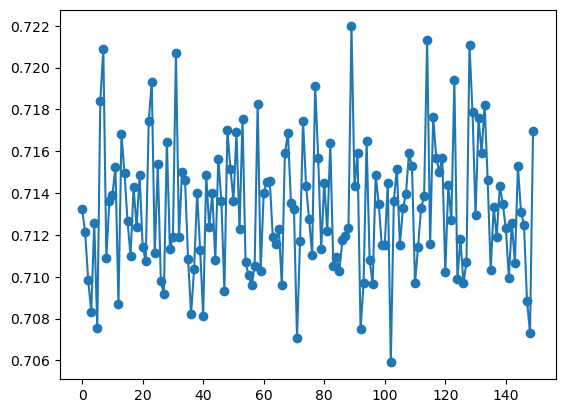

In [251]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
shuffle_split = ShuffleSplit(n_splits=150, test_size=0.2, random_state=42)

# Melakukan cross-validation dengan ShuffleSplit
scores = cross_val_score(naive_bayes, X, data['sentiment'], cv=shuffle_split, scoring='accuracy')
x = []
# Menampilkan skor akurasi untuk setiap iterasi cross-validation
for i, score in enumerate(scores):
    print(f"Iterasi {i+1}: {score}")
    x.append(score)

# Menampilkan rata-rata skor akurasi dari cross-validation
print(len(x))
print("Rata-rata skor akurasi: {:.2f} %".format(scores.mean()*100))
print("Skor tertinggi: {:.2f} %".format(scores.max()*100))
plt.plot(range(len(x)), x, marker='o')

In [252]:
acc_mnb = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.4f}".format(acc_mnb))

conf_matrix_mnb = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n {}".format(conf_matrix_mnb))
print(classification_report(y_test, y_pred))

Accuracy: 0.7132
Confusion matrix:
 [[2559 1033  109]
 [1299 5440 1344]
 [ 602 1058 5543]]
              precision    recall  f1-score   support

    Negative       0.57      0.69      0.63      3701
     Neutral       0.72      0.67      0.70      8083
    Positive       0.79      0.77      0.78      7203

    accuracy                           0.71     18987
   macro avg       0.70      0.71      0.70     18987
weighted avg       0.72      0.71      0.72     18987



[[2559 1033  109]
 [1299 5440 1344]
 [ 602 1058 5543]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


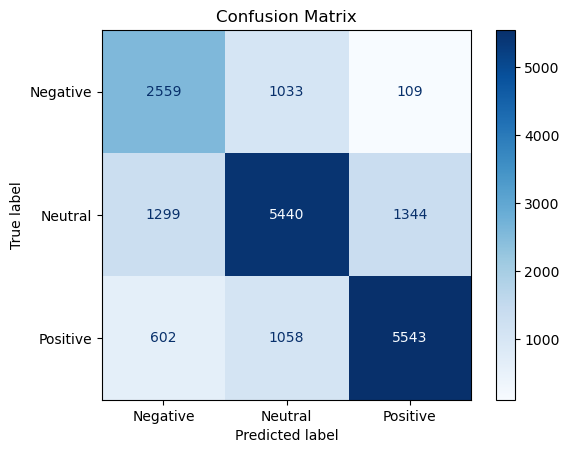

In [253]:
class_names = sorted(data['sentiment'].unique())
disp = plot_confusion_matrix(training, X_test, y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues, values_format='d')
disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)

plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[10931  3521   373]
 [ 3488 24652  4415]
 [ 1686  2992 23888]]


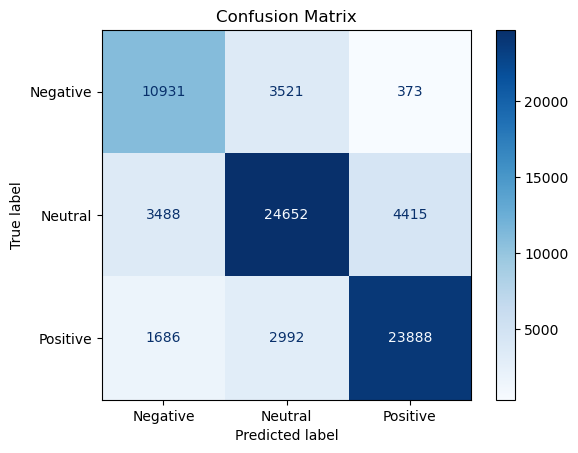

In [254]:
class_names = sorted(data['sentiment'].unique())
disp = plot_confusion_matrix(training, X_train, y_train,
                              display_labels=class_names,
                              cmap=plt.cm.Blues, values_format='d')
disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)

plt.show()

In [255]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi pada data uji
y_pred = naive_bayes.predict(X_test)

# Menghitung dan menampilkan akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:{:.2f}%".format(accuracy * 100))

# Menghitung dan menampilkan presisi
precision = precision_score(y_test, y_pred, average='weighted')
print("Presisi: {:.2f}%".format(precision * 100))

# Menghitung dan menampilkan recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:{:.2f}%".format(recall * 100))

# Menghitung dan menampilkan F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:{:.2f}%".format(f1 * 100))
positive_count = (y_pred == 'Positive').sum()
negative_count = (y_pred == 'Negative').sum()
neutral_count = (y_pred == 'Neutral').sum()
total_count = len(y_pred)
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100
neutral_percentage = (neutral_count / total_count) * 100
    # Tampilkan hasil
print("Persentase Klasifikasi:")
print("Positif: {:.1f}%".format(positive_percentage))
print("Negatif: {:.1f}%".format(negative_percentage))
print("Netral: {:.1f}%".format(neutral_percentage))
print("total:{}".format(total_count))

Akurasi:71.32%
Presisi: 71.99%
Recall:71.32%
F1-score:71.51%
Persentase Klasifikasi:
Positif: 36.8%
Negatif: 23.5%
Netral: 39.7%
total:18987


In [256]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi pada data uji
y_pred = naive_bayes.predict(X_train)

# Menghitung dan menampilkan akurasi
accuracy1 = accuracy_score(y_train, y_pred)
print("Akurasi:{:.2f}%".format(accuracy1 * 100))

# Menghitung dan menampilkan presisi
precision1 = precision_score(y_train, y_pred, average='weighted')
print("Presisi: {:.2f}%".format(precision1 * 100))

# Menghitung dan menampilkan recall
recall1 = recall_score(y_train, y_pred, average='weighted')
print("Recall:{:.2f}%".format(recall1 * 100))

# Menghitung dan menampilkan F1-score
f11 = f1_score(y_train, y_pred, average='weighted')
print("F1-score:{:.2f}%".format(f11 * 100))
positive_count = (y_pred == 'Positive').sum()
negative_count = (y_pred == 'Negative').sum()
neutral_count = (y_pred == 'Neutral').sum()
total_count = len(y_pred)
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100
neutral_percentage = (neutral_count / total_count) * 100
    # Tampilkan hasil
print("Persentase Klasifikasi:")
print("Positif: {:.1f}%".format(positive_percentage))
print("Negatif: {:.1f}%".format(negative_percentage))
print("Netral: {:.1f}%".format(neutral_percentage))
print("total: {:.1f}%".format(total_count))

Akurasi:78.31%


Presisi: 78.49%
Recall:78.31%
F1-score:78.36%
Persentase Klasifikasi:
Positif: 37.8%
Negatif: 21.2%
Netral: 41.0%
total: 75946.0%


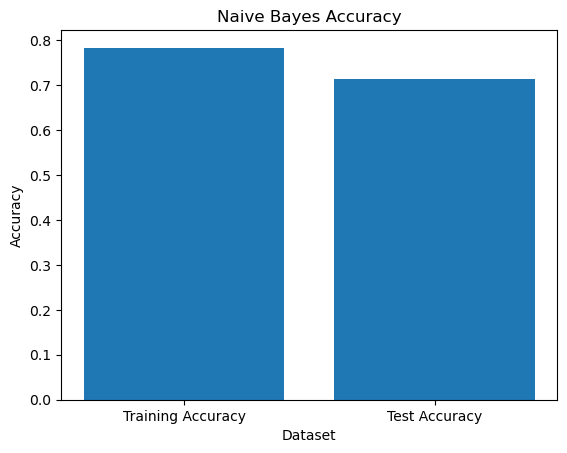

0.06984471136960602
0.7830695494166908
0.7132248380470848


In [257]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Melatih model Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

# Memprediksi label pada data latih dan data uji
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Menghitung akurasi pada data latih dan data uji
akurasi_train = accuracy_score(y_train, y_train_pred)
akurasi_test = accuracy_score(y_test, y_test_pred)

# Membuat grafik akurasi
labels = ['Training Accuracy', 'Test Accuracy']
values = [akurasi_train, akurasi_test]

plt.bar(labels, values)
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Accuracy')
plt.show()

print(akurasi_train - akurasi_test)
print(akurasi_train)
print(akurasi_test)

[0.19192558 0.14443799 0.12628342 0.1143403  0.10794343 0.1004645
 0.09537437 0.09042295 0.08524885 0.08221988]


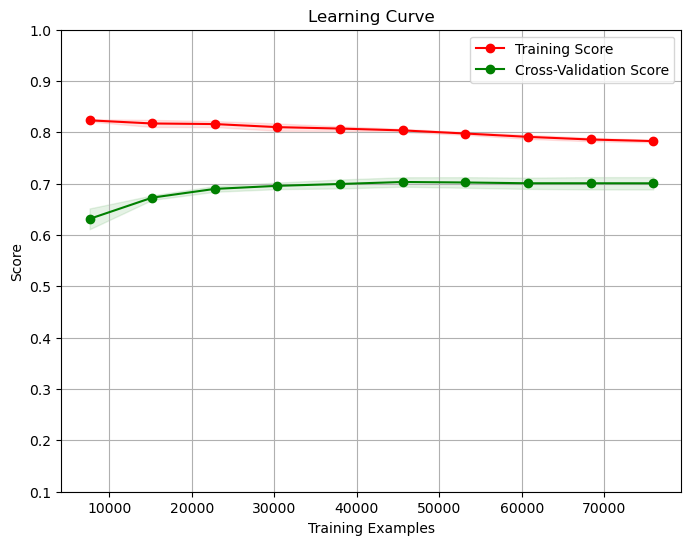

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.ylim(0.1, 1)
    print(train_scores_mean - test_scores_mean)
    plt.legend(loc='best')
    plt.show()

# learning curve
estimator = MultinomialNB()
plot_learning_curve(estimator, X, data['sentiment'])


In [259]:
data.tweet.iloc[3]

'lolos pemilu partai ummat bahas dukung pilpres'

In [260]:
while True:
    # Memasukkan input teks
    input_text = input("Masukkan teks (atau ketik 'selesai' untuk keluar): ")
    
    # Keluar dari loop jika pengguna memasukkan 'selesai'
    if input_text.lower() == 'selesai':
        break
    a = input_text
    # Melakukan transformasi teks input menjadi vektor fitur
    stem = stemmer.stem(a)
    clean = stopword_remover.remove(stem)
    X_input = vectorizer.transform([clean])
    
    # Melakukan prediksi pada input
    pred = naive_bayes.predict(X_input)
    positive_count = (y_pred == 'Positive').sum()
    negative_count = (y_pred == 'Negative').sum()
    neutral_count = (y_pred == 'Neutral').sum()
    na = model.predict_proba(X_input)
    # Menampilkan hasil prediksi
    print(clean)
    print("Hasil Prediksi: ", pred[0], na)
    print()

In [261]:
import pickle
# # from sklearn.feature_extraction.text import CountVectorizer
# # from sklearn.model_selection import train_test_split
# # from sklearn.naive_bayes import MultinomialNB
# # from sklearn.metrics import accuracy_score

# # # Inisialisasi objek CountVectorizer
# # vectorizer = CountVectorizer()

# # # Melakukan transformasi teks menjadi vektor fitur
# # X = vectorizer.fit_transform(data['tweet'].astype(str))

# # epoch = 1
# # accuracy_values = np.zeros(epoch)

# # # Membagi data menjadi data latih dan data uji
# # for epochs in range(epoch):
# #     X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.2, random_state=42)
# #     naive_bayes = MultinomialNB()
# #     training = naive_bayes.fit(X_train, y_train)
# #     prediction =  naive_bayes.predict(X_test)

# #     accuracy = accuracy_score(y_test, prediction)
# #     accuracy_values[epochs] = accuracy

# #     print("epoch:", epochs + 1, "acc:", accuracy)

# # Export model dan objek CountVectorizer menjadi file pickle
model_data = {
    'model': naive_bayes,
    'vectorizer': vectorizer
}

with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)


In [262]:
len(data)

94933

In [263]:
nana = ['cobain ini']  # Data teks kalimat uji (numpy array atau pandas Series)

# Mengubah data uji menjadi fitur kata yang sesuai
X_test_features = vectorizer.transform(nana)
# Menghitung probabilitas prediksi sentimen untuk setiap kalimat
sentiment_probabilities = model.predict_proba(X_test_features)

# Menghitung persentase nilai sentimen untuk setiap kalimat
positive_percentages = sentiment_probabilities[:, 2] * 100
netral_percentages = sentiment_probabilities[:, 1] * 100
negative_percentages = sentiment_probabilities[:, 0] * 100

# Menampilkan hasil persentase nilai sentimen setiap kalimat
for i in range(len(nana)):
    print(f"Kalimat: {nana[i]}")
    print(f"Persentase Sentimen Positif: {positive_percentages[i]:.2f}%")
    print(f"Persentase Sentimen Netral: {netral_percentages[i]:.2f}%")
    print(f"Persentase Sentimen Negatif: {negative_percentages[i]:.2f}%")
    print()

Kalimat: cobain ini
Persentase Sentimen Positif: 66.40%
Persentase Sentimen Netral: 19.98%
Persentase Sentimen Negatif: 13.63%



In [264]:
# Menghitung probabilitas sentimen untuk setiap kata dalam kalimat
while True:
    # Memasukkan input teks
    input_text = input("Masukkan teks (atau ketik 'selesai' untuk keluar): ")
    
    # Keluar dari loop jika pengguna memasukkan 'selesai'
    if input_text.lower() == 'selesai':
        break
    def calculate_word_sentiment_probabilities(text):
        stem_text = stemmer.stem(text)
        clean_text = stopword_remover.remove(stem_text)
        words = clean_text.split()
        word_sentiment_probabilities = []

        for word in words:
            text_vectorized = vectorizer.transform([word])
            proba = model.predict_proba(text_vectorized)[0]
            sentiment_probabilities = {
                'Word': word,
                'Positive': proba[2],
                'Negative': proba[0],
                'Neutral': proba[1]
            }
            word_sentiment_probabilities.append(sentiment_probabilities)

        return word_sentiment_probabilities

    # Kalimat yang akan dianalisis sentimennya
    # sentence = "prabowo ganjar anies"

    # Menghitung probabilitas sentimen untuk setiap kata dalam kalimat
    word_probabilities = calculate_word_sentiment_probabilities(input_text)

    # Menampilkan hasil probabilitas sentimen untuk setiap kata
    for word_probability in word_probabilities:
        word = word_probability['Word']
        positive_proba = word_probability['Positive']
        negative_proba = word_probability['Negative']
        neutral_proba = word_probability['Neutral']
        print(f"Kata: {word}")
        print(f"Probabilitas Sentimen Positif: {positive_proba:.2f}")
        print(f"Probabilitas Sentimen Negatif: {negative_proba:.2f}")
        print(f"Probabilitas Sentimen Netral: {neutral_proba:.2f}")
        print()


pos = 0,0156674
net = 0,0363699
neg = 0,001899

total = 0,0539363

In [265]:
len(data)

94933

In [266]:
len(y_train)

75946

In [267]:
len(y_test)

18987

In [268]:
X.sum()

1130132

In [269]:
y_train.value_counts()

Neutral     32555
Positive    28566
Negative    14825
Name: sentiment, dtype: int64

In [270]:
y_test.value_counts()

Neutral     8083
Positive    7203
Negative    3701
Name: sentiment, dtype: int64

In [271]:
data.sentiment.value_counts()

Neutral     40638
Positive    35769
Negative    18526
Name: sentiment, dtype: int64